In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

plt.style.use('seaborn')

In [2]:
class isingModel:
    """A class to create a lattice to generate Ising Model

    Attributes:
        N: The number of lines of lattice
        M: The number of columms of lattice
        beta: The parameter that represent the inverse of temperature
        
    Return:
        A class python object with several methods:
            + display_spin_field()
            + ising_step()
            + animation()            
    """    
    def __init__(self, N, M, beta):
        self.N = N
        self.M = M
        self.beta = beta
        self.field = np.random.choice([-1, 1], size=(self.N, self.M))
        self.images = [self.field]

    def display_spin_field(self):
        return Image.fromarray(np.uint8((self.field + 1) * 0.5 * 255))

    def ising_step(self):
        N, M = self.field.shape
        for n_offset in range(2):
            for m_offset in range(2):
                for n in range(n_offset, N, 2):
                    for m in range(m_offset, M, 2):
                        self._ising_update(n, m)
        return self.field
    
    def _ising_update(self, n, m):
        total = 0
        N, M = self.field.shape
        for i in range(n-1, n+2):
            for j in range(m-1, m+2):
                if i == n and j == m:
                    continue
                total += self.field[i % N, j % M]
        dE = 2 * self.field[n, m] * total
        if dE <= 0:
            self.field[n, m] *= -1
        elif np.exp(-dE * self.beta) > np.random.rand():
            self.field[n, m] *= -1          

In [3]:
lattice = isingModel(200,200, 0.4)

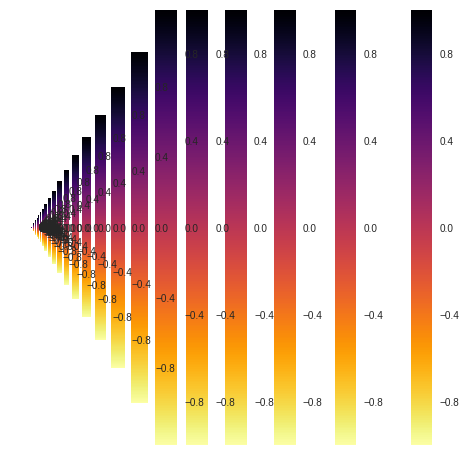

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

def update(i):
    sns.heatmap(lattice.ising_step(), ax=ax, cmap=plt.cm.inferno_r)    
    ax.set_axis_off()
    plt.close()

anim = animation.FuncAnimation(fig, update, frames=30, interval=50)
anim.save('colour_rotation.gif', dpi=80, writer='imagemagick')
plt.show()